# 1. Stroke prediction using Machine Learning

In this section we are going to predict if the patient will have a stroke or not. We will use Random Forest Classifier and KNN Classifier to predict the stroke. We will also use SMOTE to balance the data, since the "no-stroke" data is the majority class with a lot more data than the "stroke" data.

In [37]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_csv('./data/stroke-data-cleaned.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   ever_married                    5110 non-null   int64  
 4   avg_glucose_level               5110 non-null   float64
 5   bmi                             5110 non-null   float64
 6   stroke                          5110 non-null   int64  
 7   gender_female                   5110 non-null   int64  
 8   gender_male                     5110 non-null   int64  
 9   work_govt_job                   5110 non-null   int64  
 10  work_never_worked               5110 non-null   int64  
 11  work_private                    5110 non-null   int64  
 12  work_self_employed              51

# 1.1 Standardize, train, test split and SMOTE

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = df.drop('stroke', axis=1)
y = df['stroke']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=4321)

# Perform standardization on the numerical features
scaler = StandardScaler()
num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_stand = X_train.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])
X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_stand, y_train)
X_val_smote, y_val_smote = smote.fit_resample(X_val_stand, y_val)

In [40]:
original_counts = y_train.value_counts()
resampled_counts = y_train_smote.value_counts()

print('Original counts: ', original_counts, '\n', 'Resampled counts: ', resampled_counts)

Original counts:  stroke
0    3123
1     147
Name: count, dtype: int64 
 Resampled counts:  stroke
0    3123
1    3123
Name: count, dtype: int64


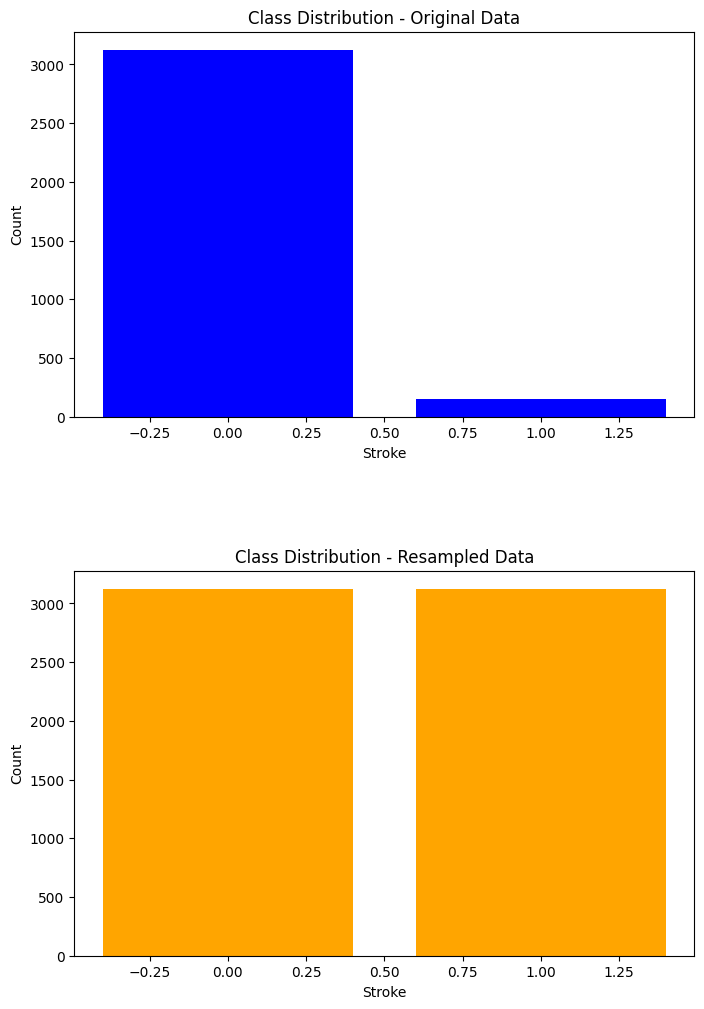

In [41]:
import matplotlib.pyplot as plt

original_counts = y_train.value_counts()
resampled_counts = y_train_smote.value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.bar(original_counts.index, original_counts.values, color='blue')
ax1.set_xlabel('Stroke')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution - Original Data')

ax2.bar(resampled_counts.index, resampled_counts.values, color='orange')
ax2.set_xlabel('Stroke')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution - Resampled Data')

plt.subplots_adjust(hspace=0.4)

plt.show()

## 1.2 KNN Classification

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

n_neighbors = np.arange(1,60)
param_grid = {'n_neighbors': n_neighbors}

prec_scorer = make_scorer(accuracy_score)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=prec_scorer ,cv=3,  verbose=2, n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)
grid_search.best_params_

Fitting 3 folds for each of 59 candidates, totalling 177 fits


{'n_neighbors': 1}

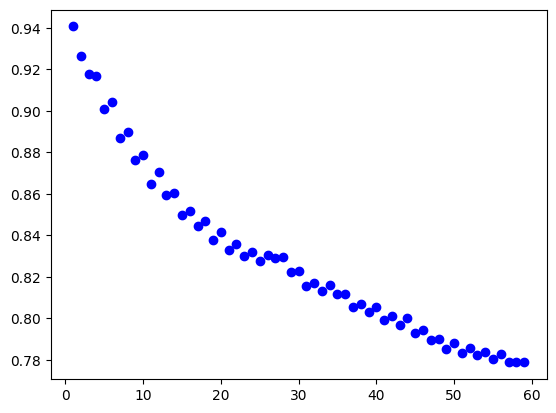

In [43]:
out2 = pd.DataFrame(grid_search.cv_results_)
xlabel_names = ['n_neighbors']
plt.scatter(out2['param_n_neighbors'], out2['mean_test_score'], c='blue')

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_val_smote)
print(classification_report(y_val_smote, y_pred))


preds_knn = grid_search.predict_proba(X_val_smote)[:,1]

              precision    recall  f1-score   support

           0       0.58      0.95      0.72       767
           1       0.86      0.32      0.47       767

    accuracy                           0.63      1534
   macro avg       0.72      0.63      0.60      1534
weighted avg       0.72      0.63      0.60      1534



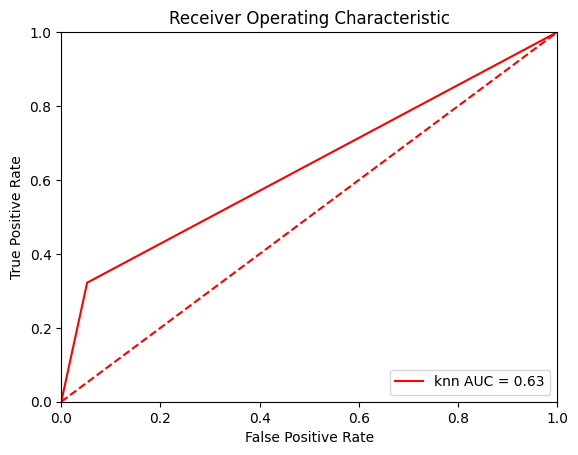

In [47]:
# plotting the polynomial AUC together with the last one
import sklearn.metrics as metrics

fpr_k, tpr_k, threshold = metrics.roc_curve(y_val_smote, preds_knn)

roc_auc_k = metrics.auc(fpr_k, tpr_k)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 1.3 Gradient Boosting Classifier

In [48]:
# RandomizedSearch with cross validation using the GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start=100, stop=250, num=50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 10, num=10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num=9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num=10)]
learning_rate = [round(x,5) for x in np.linspace(start=0.001, stop=1.5, num=50)]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions=random_grid, n_iter=50, cv=3, verbose=2, random_state=4872, n_jobs=-1)
gbm_random.fit(X_train_smote, y_train_smote)
gbm_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

{'n_estimators': 145,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 8,
 'learning_rate': 0.27633}

In [49]:
# classification report

y_pred_gbm = gbm_random.predict(X_val_stand)
print(classification_report(y_val, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       767
           1       0.12      0.04      0.06        51

    accuracy                           0.92       818
   macro avg       0.53      0.51      0.51       818
weighted avg       0.89      0.92      0.90       818



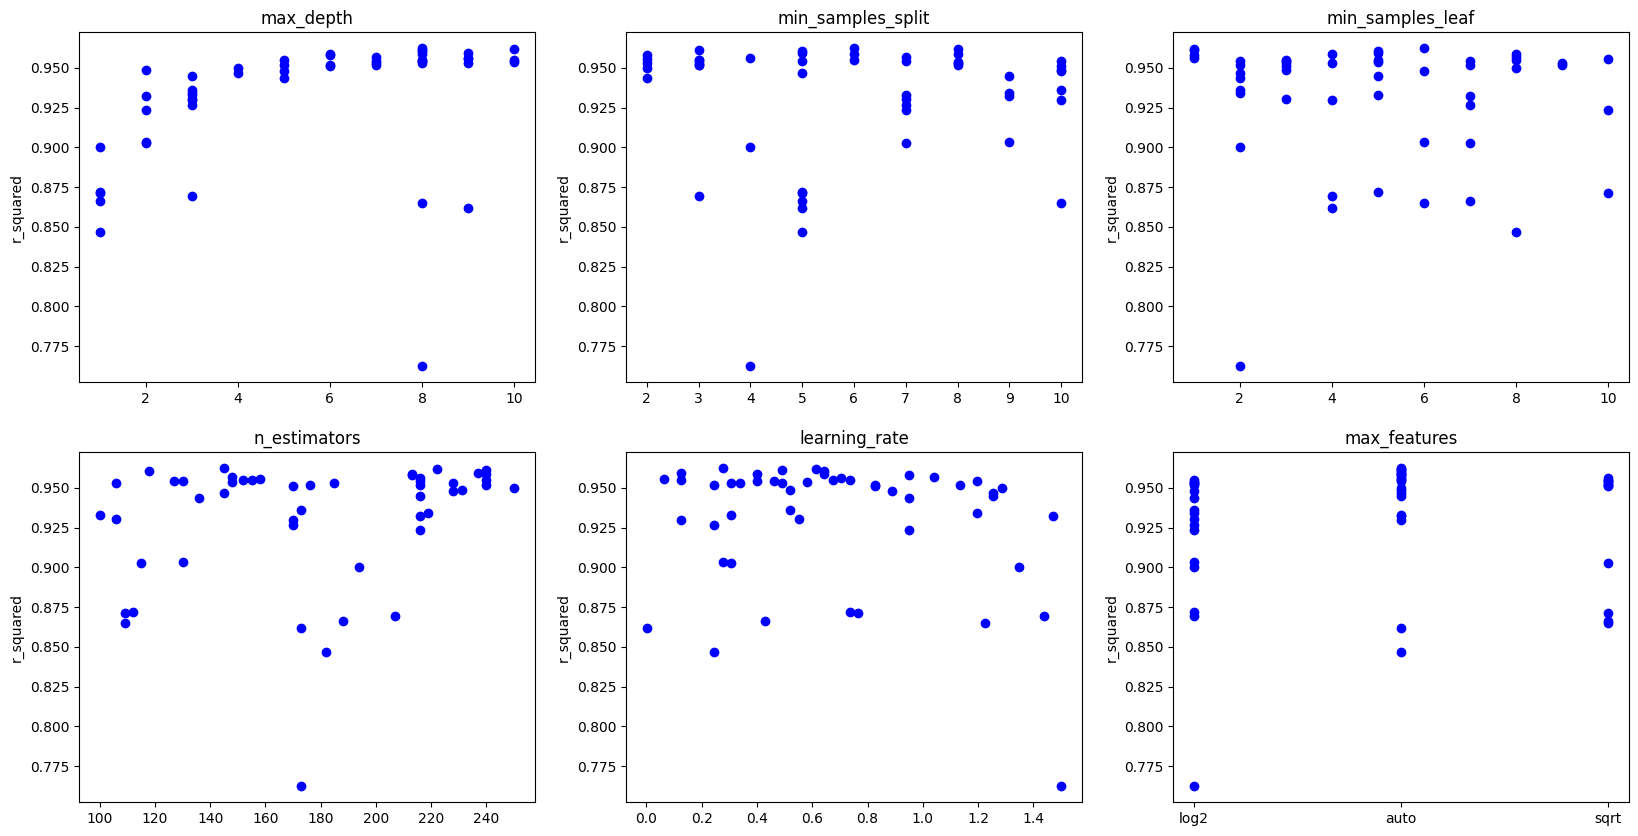

In [50]:
# plotting out the best parameters to use in the grid search

out2 = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_learning_rate','param_max_features']

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue')
axs[1,1].set_title('learning_rate')

axs[1,2].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue')
axs[1,2].set_title('max_features')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

n_estimators = [int(x) for x in np.linspace(start=140, stop=150, num=10)]
learning_rate = [x for x in np.linspace(0.61, 0.63, num=3)]

max_features = ['auto']
max_depth = [8, 10]
min_samples_split = [3, 5]
min_samples_leaf = [1, 5]
       
random_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

gbm = GradientBoostingClassifier()
gbm_grid = GridSearchCV(estimator=gbm, param_grid=random_grid, cv=3, verbose=2, n_jobs=-1)

isotonic_gbm = CalibratedClassifierCV(gbm_grid, cv=3, method='isotonic')
isotonic_gbm.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

Fitting 3 folds for each of 240 candidates, totalling 720 fits


c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

Fitting 3 folds for each of 240 candidates, totalling 720 fits


c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\stroke-prediction-N-eXagyj\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=GradientBoostingClassifier(),
                                              n_jobs=-1,
                                              param_grid={'learning_rate': [0.61,
                                                                            0.62,
                                                                            0.63],
                                                          'max_depth': [8, 10],
                                                          'max_features': ['auto'],
                                                          'min_samples_leaf': [1,
                                                                               5],
                                                          'min_samples_split': [3,
                                                                                5],
                                                          'n_estimators': [140,
                                                                           141,
                                                                           142,
                                                                           143,
                                                                           144,
                                                                           145,
                                                                           146,
                                                                           147,
                                                                           148,
                                                                           150]},
                                              verbose=2),
                       method='isotonic')

In [57]:
# classification report

y_pred_gbm = isotonic_gbm.predict(X_val_smote)
print(classification_report(y_val_smote, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       767
           1       0.97      0.83      0.90       767

    accuracy                           0.90      1534
   macro avg       0.91      0.90      0.90      1534
weighted avg       0.91      0.90      0.90      1534



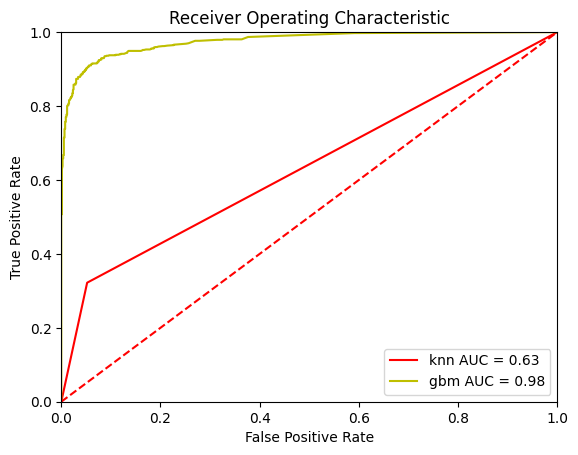

In [59]:
# plotting the results

preds_gbm = isotonic_gbm.predict_proba(X_val_smote)[:,1]

fpr_k, tpr_k, threshold = metrics.roc_curve(y_val_smote, preds_knn)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val_smote, preds_gbm)

roc_auc_k = metrics.auc(fpr_k, tpr_k)
roc_auc_g = metrics.auc(fpr_g, tpr_g)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Looking at this ROC curve, we can see that the Gradient Boosting Classifier is the best model to predict the stroke. It has the highest AUC score of 0.98. The KNN Classifier has the lowest AUC score of 0.63.

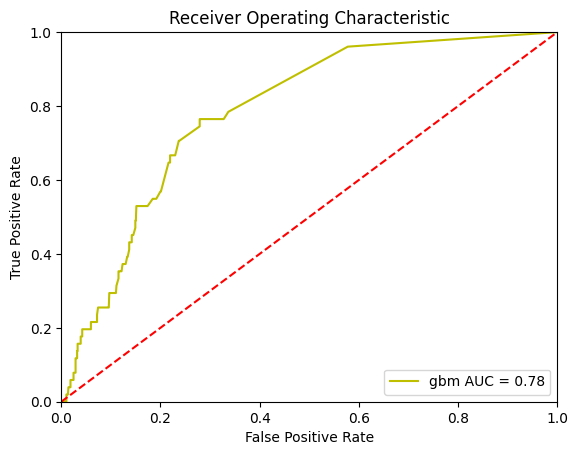

In [75]:
# plotting the ROC curve using test data

preds_gbm = isotonic_gbm.predict_proba(X_test_stand)[:,1]
fpr_g, tpr_g, threshold = metrics.roc_curve(y_test, preds_gbm)
roc_auc_g = metrics.auc(fpr_g, tpr_g)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
import pickle

# save the model

filename = 'models/gbm_model.pkl'
pickle.dump(isotonic_gbm, open(filename, 'wb'))